In [1]:
import os
import sys

In [2]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [3]:
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    # code required by Colab
    %cd /content/drive/MyDrive/PatMatBaselineAlena

    root_dir = '/content/drive/MyDrive/PatMatBaselineAlena'
else:
    current_dir = os.getcwd()
    if current_dir.endswith("notebooks"):
        root_dir = '..'
        %cd ..
    else:
        root_dir = '.'

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


In [5]:
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), root_dir))
sys.path.append(current_dir)

In [ ]:
# install requirements
%pip install -r requirements.txt

In [7]:
import json
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, matthews_corrcoef
import numpy as np
import numpy as np
from datetime import datetime
import mlflow
import matplotlib.pyplot as plt

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# # this code uploads the credentials to MLflow given in the .env file
from src.settings import (
    MLFLOW_TRACKING_URI,
    MLFLOW_TRACKING_USERNAME,
    MLFLOW_TRACKING_PASSWORD
)

In [9]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [10]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cpu')

In [ ]:
model_name = "roberta-base"

In [12]:
if model_name == "roberta-base":
    # Load the tokenizer
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    # Load the pre-trained ROBERTA model for sequence classification
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
else:
    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load the pre-trained BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

In [14]:
def print_memory_usage():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

In [15]:
print("Before loading model:")
print_memory_usage()

Before loading model:
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [18]:
# Move the model to the proper device
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [19]:
print("After loading model:")
print_memory_usage()

After loading model:
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


In [20]:
print(f"The maximum sequence length for this BERT model is: {tokenizer.model_max_length}")

The maximum sequence length for this BERT model is: 512


In [21]:
def load_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/train_v2.jsonl')
validation_data = load_jsonl('data/test_v2.jsonl')

# Prepare the texts and labels
train_texts = [(item['text'], item['text_b']) for item in train_data]
train_labels = [item['label'] for item in train_data]
validation_texts = [(item['text'], item['text_b']) for item in validation_data]
validation_labels = [item['label'] for item in validation_data]

In [22]:
len(train_texts), len(train_labels), len(validation_texts), len(validation_labels)

(2920, 2920, 730, 730)

In [23]:
# If you don't have a GPU, limit the amount of data
if device.type == 'cpu':
    train_texts = train_texts[:10]
    train_labels = train_labels[:10]
    validation_texts = validation_texts[:10]
    validation_labels = validation_labels[:10]

The number of words at which 95% of the texts fit is: 227.6


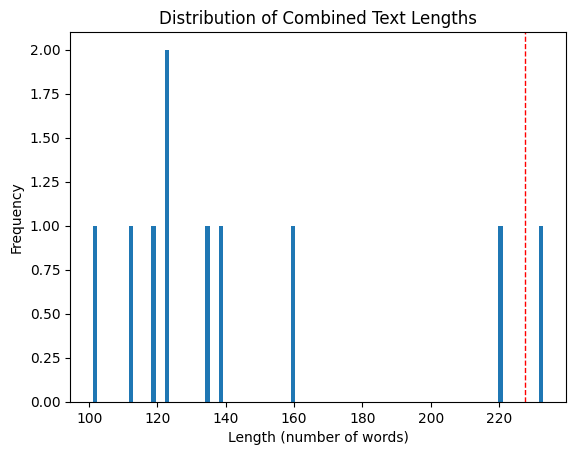

In [24]:
doc_lengths = [len((item[0] + " " + item[1]).split()) for item in train_texts]

sorted_lengths = np.sort(doc_lengths)

percentile_95_length = np.percentile(sorted_lengths, 95)
print(f"The number of words at which 95% of the texts fit is: {percentile_95_length}")

# Visualize the distribution of the lengths of the combined texts
plt.hist(doc_lengths, bins=100)
plt.axvline(percentile_95_length, color='r', linestyle='dashed', linewidth=1)
plt.title('Distribution of Combined Text Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')
plt.show()

In [25]:
num_texts_below_given_length = np.sum(sorted_lengths <= 384)

percentage_texts_below_given_length = (num_texts_below_given_length / len(sorted_lengths)) * 100

print(f"The percentage of combined texts below 384 words (roughly 512 tokens) is: {percentage_texts_below_given_length:.2f}%")

The percentage of combined texts below 384 words (roughly 512 tokens) is: 100.00%


In [26]:
config = {
    'learning_rate': 2e-5,
    'lr_scheduler': "StepLR",
    'gamma': 0.1,
    'step_size': 2,
    'batch_size': 32,
    'num_epochs': 4,
    'max_length': 512,
    'test_size': 0.2,
    'random_state': 42,
    'base_model': model_name
}

In [27]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])

train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']

validation_input_ids = validation_encodings['input_ids']
validation_attention_mask = validation_encodings['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

In [28]:
decoded = tokenizer.decode(train_encodings["input_ids"][0])
print(decoded)

at_mask = train_encodings["attention_mask"][0]
print(at_mask)

<s>The cooling system according to claim 2 wherein the cabinet comprises a front side a back side opposite to the front side two opposite lateral sides a top side and a bottom side opposite to the top side.</s></s>In one embodiment a method of cooling an apparatus comprises forming a plenum on a side of a first chamber of the apparatus open to a front of the apparatus partitioning the apparatus with an airpermeable barrier forming a second chamber separated from the plenum and the first chamber by the airpermeable barrier pulling air from the front of the apparatus via the plenum through the airpermeable barrier into the second chamber and exhausting air from the second chamber to a rear of the apparatus.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [29]:
train_input_ids.shape, train_attention_mask.shape, validation_input_ids.shape, validation_attention_mask.shape

(torch.Size([10, 264]),
 torch.Size([10, 264]),
 torch.Size([10, 253]),
 torch.Size([10, 253]))

In [30]:
train_labels.shape, validation_labels.shape

(torch.Size([10]), torch.Size([10]))

In [31]:
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
validation_data = TensorDataset(validation_input_ids, validation_attention_mask, validation_labels)

In [32]:
train_data.tensors[0].shape, train_data.tensors[1].shape, train_data.tensors[2].shape

(torch.Size([10, 264]), torch.Size([10, 264]), torch.Size([10]))

In [33]:
validation_data.tensors[0].shape, validation_data.tensors[1].shape, validation_data.tensors[2].shape

(torch.Size([10, 253]), torch.Size([10, 253]), torch.Size([10]))

In [34]:
train_dataloader = DataLoader(train_data, batch_size=config["batch_size"])
validation_dataloader = DataLoader(validation_data, batch_size=config["batch_size"])

In [35]:
for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([10, 264]) torch.Size([10, 264]) torch.Size([10])


In [36]:
# Define the optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

In [37]:
user = MLFLOW_TRACKING_USERNAME
experiment_name = 'Alena_PatentMatchBaseline'


def timestamp():
    """This function creates current timestamp"""
    return datetime.now().strftime("%Y_%m_%d_%H%M_%S")

In [38]:
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None or experiment.lifecycle_stage == 'deleted':
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [39]:
save_model = True

In [40]:
if save_model:
    model_save_path = f'models/{timestamp()}'

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

In [41]:
def calculate_and_log_train_metrics_and_hp(train_loss, epoch):
    # Log the average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss}")

    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    mlflow.log_metric("learning_rate", current_lr, step=epoch)
    print(f"Current learning rate for epoch {epoch + 1}: {current_lr}")

In [42]:
def calculate_and_log_val_metrics(true_labels, predictions, epoch):
    # Calculate the accuracy of the predictions
    val_accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation Accuracy: {val_accuracy}")
    mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

    # Calculate additional metrics
    val_precision = precision_score(true_labels, predictions, zero_division='warn')
    val_recall = recall_score(true_labels, predictions, zero_division="warn")
    val_f1 = f1_score(true_labels, predictions, zero_division="warn")
    val_mcc = matthews_corrcoef(true_labels, predictions)

    # Log additional metrics
    mlflow.log_metric("val_precision", val_precision, step=epoch)
    mlflow.log_metric("val_recall", val_recall, step=epoch)
    mlflow.log_metric("val_f1", val_f1, step=epoch)
    mlflow.log_metric("val_mcc", val_mcc, step=epoch)

    print(f"Validation Precision: {val_precision}")
    print(f"Validation Recall: {val_recall}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Validation MCC: {val_mcc}")

In [43]:
def calculate_and_log_cm(true_labels, predictions, epoch):
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predictions, normalize='true')
    cm_filename = f"artifacts/{timestamp()}_confusion_matrix_epoch_{epoch}.csv"
    np.savetxt(cm_filename, cm, delimiter=",")
    mlflow.log_artifact(cm_filename)
    print(cm)

In [44]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
    for param_name, param_value in config.items():
        mlflow.log_param(param_name, param_value)

    best_val_loss = float('inf')

    for epoch in range(config['num_epochs']):  # Number of training epochs
        print(f'############### Started {epoch + 1} epoch ###############')
        
        # Set run name
        mlflow.set_tag(key='mlflow.runName', value=f'{timestamp()}_{user}')
        
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()

        calculate_and_log_train_metrics_and_hp(train_loss, epoch)

        # Validation loop
        model.eval()
        val_loss = 0.0
        predictions, true_labels = [], []
        for batch in validation_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
            true_labels.extend(b_labels.cpu().tolist())

        # Log the average validation loss for the epoch
        avg_val_loss = val_loss / len(validation_dataloader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        print(f"Average validation loss for epoch {epoch + 1}: {avg_val_loss}")
    
        calculate_and_log_val_metrics(true_labels, predictions, epoch)
        
        # Save the best model based on validation loss
        if save_model:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                model_to_save = model.module if hasattr(model, 'module') else model
                model_to_save.save_pretrained(model_save_path)
                tokenizer.save_pretrained(model_save_path)

        calculate_and_log_cm(true_labels, predictions, epoch)
        print(f'############### Finished {epoch + 1} epoch ###############\n\n')

        # Update the learning rate scheduler
        scheduler.step()

mlflow.end_run()

############### Started 1 epoch ###############
Average training loss for epoch 1: 0.7488312125205994
Current learning rate for epoch 1: 2e-05
Average validation loss for epoch 0: 0.6702248454093933
Validation Accuracy: 0.8
Validation Precision: 0.8
Validation Recall: 1.0
Validation F1 Score: 0.888888888888889
Validation MCC: 0.0
[[0. 1.]
 [0. 1.]]
############### Finished 1 epoch ###############


############### Started 2 epoch ###############
Average training loss for epoch 2: 0.6775502562522888
Current learning rate for epoch 2: 2e-05
Average validation loss for epoch 1: 0.6770456433296204
Validation Accuracy: 0.8
Validation Precision: 0.8
Validation Recall: 1.0
Validation F1 Score: 0.888888888888889
Validation MCC: 0.0
[[0. 1.]
 [0. 1.]]
############### Finished 2 epoch ###############


############### Started 3 epoch ###############
Average training loss for epoch 3: 0.7021660208702087
Current learning rate for epoch 3: 2.0000000000000003e-06
Average validation loss for epoch 2: